# Load data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
from typing import Tuple, List, Callable

In [121]:
def load_file(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the data from the file stored at :param path: and returns the 
    input values and the class labels.
    :param path: path of a CVS file with data
    :return: a tuple containing the input matrix of shape (n, p) and a line 
    vector with the m class labels in {0, ..., 9}
    """
    # citire date sin fisierul dat de path
    df = pd.read_csv(path,header=None)
    X = df.values[:,1:].T
    y = df.values[:,0].reshape(len(df),1).T
    assert X.ndim ==  2, 'Matrix required for input values'
    assert y.ndim == 2, 'Column matrix required for labels'
    assert y.shape == (1, X.shape[1]), 'Same number of lines is required'
    return X, y

In [122]:
path_train = './lab4/data/mnist_train.csv'
path_test = './lab4/data/mnist_test.csv'

In [123]:
X_train, y_train = load_file(path_train)

assert X_train.shape == (784, 60000)
assert y_train.shape == (1, 60000)

X_test, y_test = load_file(path_test)

assert X_test.shape == (784, 10000)
assert y_test.shape == (1, 10000)

In [124]:
def scale_values(X: np.ndarray) -> np.ndarray:
    """Scales the values to range [0, 1].
    :param X: an (m, n) matrix with values between 0 and 255.
    :return: an (m, n) matrix containing values of :param X: scaled in [0, 1]
    """
    result = X/255 # scrieti cod
    assert 0 <= np.min(result) <= np.max(result) <= 1, 'Scaled values should be in [0, 1]'
    assert X.shape == result.shape, 'Scaling preserves shape'
    return result

In [125]:
X_train = scale_values(X_train)
assert X_train.shape == (784, 60000)
X_test = scale_values(X_test)
assert X_test.shape == (784, 10000)

# Create model

## Define model's architecture

In [126]:
m = 10 # number of classes
n, p = X_train.shape
architecture = [n, 100, m] # list: [input_size, hidden1, hidden2, ..., output_size]

assert len(architecture) >= 3, 'At least one hidden layer'
assert architecture[0] == n
assert architecture[-1] == m

Ponderile sunt initializate conform strategiei lui Xavier Glorot. Pentru o matrice de ponderi $W^{[l]}$ de forma $n_{l} \times n_{l-1}$, ponderile pot fi initializate cu o distributie uniforma in intervalul 
$$
\left[-\frac{\sqrt{6}}{\sqrt{n_{l} + n_{l-1}}}, +\frac{\sqrt{6}}{\sqrt{n_{l} + n_{l-1}}}\right]
$$

Ponderile de bias se obisnuiesc a se initializa cu 0; intializarea aleatoare a ponderilor W este considerata suficienta pentru a obtine spargerea simetriei.

Ref: [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [127]:
def create_weights(architecture: List[int], init_type:str='glorot_uniform') -> Tuple[List[np.array], List[np.array]]:
    """Creates the list of weights and biases for the given architecture.
    :param architecture: list of number of nodes in each layer 
    (including input and ouotput layers)
    :param init_type: name of initialization parameter. Defaults to 
    'glorot_uniform', add other supported initializtion strategies.
    :return: a tuple containing: list of weight matrices W, a list of bias 
    column vectors. The two lists have the same numer of elements, number of 
    layers - 1.
    """
    L = len(architecture)
    W, b = [], []
    # initializare de ponderi
    for n_lplus1, nl in zip(architecture[1:], architecture[:-1]):
        W.append(np.random.rand(n_lplus1,nl)* np.random.uniform(-1,1) *np.sqrt(6.0 / (nl + n_lplus1)))# scrieti cod
    for n_l in architecture[1:]:
        b.append(np.zeros((n_l,1))) # scrieti cod
    assert len(W) == len(b) == L-1
    for i, w in enumerate(W):
        assert w.shape == (architecture[i+1], architecture[i]), f'Shape of W[{i}] should be ({L[i+1], L[i]})'
    for i, _b in enumerate(b):
        assert _b.shape == (architecture[i+1], 1), f'Shape of b[{i}] should be ({L[i+1]}, 1)'
    if init_type == 'glorot_uniform':
        for i, w in enumerate(W):
            w_shape_sum = np.sum(w.shape)
            assert -np.sqrt(6)/np.sqrt(w_shape_sum) <= np.min(w) <= np.sqrt(6)/np.sqrt(w_shape_sum), f"Values of W[{i}] should be according to Glorot's initialization"
        for i, _b in enumerate(b):
            assert 0 == np.min(_b) == np.min(_b) == 0, f"Values of b[{i}] should be initialized to 0"
    return W, b

In [128]:
def sigmoid(z: np.array) -> np.array:
    """Computes sigmoid activation function"""
    # scrieti cod
    return 1 / (1 + np.exp(-z))

def derivate_sigmoid(z: np.array) -> np.array:
    """Computes the derivatives for the sigmoid activation function"""
    # scrieti cod
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z: np.array) -> np.array:
    """Computes the tanh activation function"""
    # scrieti cod
    return np.tanh(z)

def derivate_tanh(z: np.array) -> np.array:
    """Computes the derivatives for the tanh activation function"""
    # scrieti cod
    return 1.0 - np.tanh(z)**2

def ReLU(z: np.array) -> np.array:
    """Computes the rectified linear unit activation function"""
    return np.maximum(0,z)

def derivative_ReLU(z: np.array) -> np.array:
    """Computes the derivatives of the rectified linear unit activation function"""
    # scrieti cod
    z[z <= 0.0] = 0.0
    z[z > 0.0] = 1.0
    return z

In [129]:
def softmax(z, axis=0):
    """Applies softmax to a matrix z.
    :param z: np.array of shape (m, k)
    """
    # scrieti cod, posibil mai multe linii
    result = np.exp(z) / np.sum(np.exp(z), axis=0)
    assert np.allclose(np.sum(result, axis=axis), 1.0)
    return result

In [130]:
W, b = create_weights(architecture=architecture)

## Feedforward propagation

In [131]:
def can_multiply(a:np.array, b:np.array) -> bool:
    return a.ndim == b.ndim == 2 and a.shape[1] == b.shape[0]

def can_multiply_hadamard(a:np.array, b:np.array) -> bool:
    return a.shape == b.shape

In [132]:
def model(X:np.array, W:List[np.array], b:List[np.array], f:List[Callable]) -> np.array:
    """Computes the output produced by the MLP for the given input X
    :param X: np.array of shape (n, p). Each column of X is a datum from a set.
    :param W: a list of weight matrices
    :param b: a list of bias columns
    :param f: a list of activation functions
    :return: a matrix of output values produced by MLP, of shape: number of 
    predicted outputs (e.g. classes), number of input vectors p
    """
    assert len(W) == len(b) == len(f)
    p = X.shape[1]
    a = X
    for i, (_w, _b, _f) in enumerate(zip(W, b, f)):
        # variabila i poate fi folosita pentru debug
        assert can_multiply(_w, a)
        z = np.dot(_w, a) + _b # scrieti cod
        assert z.shape == (_w.shape[0], p)
        a = _f(z) # scrieti cod
        assert a.shape == z.shape
    assert a.shape == (W[-1].shape[0], p)
    return a

In [133]:
# f[0] = functia de activare pe primul strat ascuns; 
# f[1] = functia de activare pe al doilea strat ascuns etc.
f = [sigmoid, softmax] 
y_hat = model(X_train, W, b, f)

assert y_hat.shape == (m, p)
assert np.allclose(y_hat.sum(axis=0), np.ones(p))

## Error function

In [134]:
def J(X, y, W, b, f, num_classes=10, _lambda=0.01):
    """Computes the error function for MLP
    :param X: np.array of shape (n, k)
    :param y: np.array of shape (1, k)
    :param W: list pf MLPs weights
    :param b: list pf MLPs biases
    :return: loss values, composed of cross entropy + penalty term
    """
    p = X.shape[1]
    EPS = 1e-5
    # computes a one hot encoding for the given classes:
    # if y[i]=c, 0 <= c <= 9 (here), then column i in one_hot_encoding is filled
    # in with 0, excepting line c where one finds value 1
    if y.shape[0] == 1 :
        one_hot_encoding = np.zeros((p,num_classes))
        one_hot_encoding[np.arange(y.shape[1]), y] = 1
        one_hot_encoding = one_hot_encoding.T
        y= one_hot_encoding
        assert np.allclose(one_hot_encoding.sum(axis=0), np.ones(p))    
    assert np.allclose(y.sum(axis=0), np.ones(p))   
    predicted = model(X, W, b, f)
    predicted = np.clip(predicted, EPS, 1-EPS)
    loss1 = -(1.0 / p) *np.sum(np.multiply(np.log(predicted),y)) # scrieti cod 
    loss2 = + (_lambda / (2 * p)) * (LA.norm(W[0]) + LA.norm(W[1]))
    return loss1 + loss2


In [135]:
def accuracy(X:np.array, y:np.array, W: List[np.array], b: List[np.array], f:List[Callable]) -> float:
    """Computes the accuracy on a given input dataset X, with ground truth y
    :param X: np.array of shape (n, k)
    :param y: np.array of shape (1, k); each value is the index of a class
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activation functions. the last one must be softmax
    :return: ratio between correctly classified vectors and total number of cases
    """
    y_hat = model(X,W,b,f)
    y_predicted = np.expand_dims(np.argmax(y_hat, axis=0), axis=0) # scrieti cod
    return (y_predicted == y).sum() / X.shape[1]


### Back_propagation


In [136]:
def back_propagation(X, y_hat, y, W, b, _lambda):  

    z1 = np.dot(W[0], X) + b[0]
    a1 = f[0](z1)

    delta2 = (1.0 / X.shape[1]) * (y_hat - y)
    delta_theta2 = np.dot(a1, delta2.T) + (_lambda / X.shape[1]) * W[1].T
    delta_b2 = np.sum(delta2, axis=1, keepdims=True)
    delta1 = np.dot(W[1].T, delta2) * derivate_sigmoid(a1)

    delta_theta1 = np.dot(X, delta1.T) + (_lambda / X.shape[1]) * W[0].T
    delta_b1 = np.sum(delta1, axis=1, keepdims=True)
    return delta_theta2.T, delta_b2, delta_theta1.T, delta_b1


# Train model

In [139]:
def train(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array, num_classes, W: List[np.array],
          b: List[np.array], f: List[Callable], _lambda: float, alpha: float, max_delta_error: float = 1e-4) -> Tuple[
    List[np.array], List[np.array], List[float], List[float], List[float]]:
    """Runs the training on the training dataset (X, y). Stops when
    difference between  two succesive error values is lower than :param max_delta_error:
    :param X_train: np.array of shape (n, k), with training cases. Each column is a training case
    :param y_train: np.array of shape (1, k), containing labels (0=class 0, ...)
    :param X_test: np.array of shape (n, l), with test cases. Each column is a test vector
    :param y_test: np.array of shape (1, l), containing labels (0=class 0, ...)
    :param num_classes: number of classes
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activations functions; the last one must be softmax
    :param _lambda: coefficient >= for the L2 penalty term
    :param alpha: > 0, learning rate
    :max_delta_error: >0, a threshold for max absolute difference of succesive loss values
    :return: a tuple consisting of: list of weight matrices, list of biases, list of errors computed at each epoch on training set, 2 lists of accuracies on training and on test set at each epoch
    """
    errors = [J(X_train, y_train, W, b, f, num_classes, _lambda)]
    acc_train = [accuracy(X_train, y_train, W, b, f)]
    acc_test = [accuracy(X_test, y_test, W, b, f)]
    epoch = 0

    iterations = X_train.shape[1] / batch_size
    while True:
        batch_loss = 0
        epoch += 1
        for it in range(int(iterations)):
            X_batch = X_train[:, it * batch_size:(it + 1) * batch_size]

            one_hot_encoding = np.zeros((X_train.shape[1], 10))
            one_hot_encoding[np.arange(y_train.shape[1]), y_train] = 1
            one_hot_encoding = one_hot_encoding.T
            y_batch = one_hot_encoding[:, it * batch_size:(it + 1) * batch_size]

            # actualizare ponderi si biases W, b pentru fiecare pereche de date din setul de instruire *_test
            error = J(X_batch, y_batch, W, b, f, num_classes, _lambda)
            batch_loss += error

            y_hat = model(X_batch, W, b, f)
            gradients = back_propagation(X_batch, y_hat, y_batch, W, b, _lambda)

            W[1] = W[1] - alpha * gradients[0]
            b[1] = b[1] - alpha * gradients[1]
            W[0] = W[0] - alpha * gradients[2]
            b[0] = b[0] - alpha * gradients[3]

        error = batch_loss / iterations
        errors.append(error)
        train_acc = accuracy(X_train, y_train, W, b, f)  # scrieti cod
        acc_train.append(train_acc)
        test_acc = accuracy(X_test, y_test, W, b, f)  # scrieti cod
        acc_test.append(test_acc)

        print(f'Epoch: {epoch}, error: {error}, train accuracy: {train_acc}, test accuracy: {test_acc}')

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, error: {error}, train accuracy: {train_acc}, test accuracy: {test_acc}')
        if np.abs(errors[-1] - errors[-2]) < max_delta_error:
            break
        test_loss = J(X_test, y_test, W, b, f, num_classes, _lambda)

    return W, b, errors, acc_train, acc_test, test_loss  # scrieti cod

In [140]:
W, b = create_weights(architecture)
batch_size = 1000
W, b, errors, acc_train, acc_test,test_loss = train(X_train, y_train,X_test,y_test, num_classes =10, W = W, b=b,f=f,_lambda = 0.01 ,alpha=0.5 ,max_delta_error =1e-4)

Epoch: 1, error: 2.2863598449825067, train accuracy: 0.6229, test accuracy: 0.6363
Epoch: 2, error: 1.0332534143873402, train accuracy: 0.81775, test accuracy: 0.8188
Epoch: 3, error: 0.6110243878561843, train accuracy: 0.8611, test accuracy: 0.8677
Epoch: 4, error: 0.48688285129552666, train accuracy: 0.87975, test accuracy: 0.8842
Epoch: 5, error: 0.4272897144587671, train accuracy: 0.8888166666666667, test accuracy: 0.8915
Epoch: 6, error: 0.3923921819711388, train accuracy: 0.8952333333333333, test accuracy: 0.8984
Epoch: 7, error: 0.3694537130266253, train accuracy: 0.8995166666666666, test accuracy: 0.9029
Epoch: 8, error: 0.3531532851125286, train accuracy: 0.9026666666666666, test accuracy: 0.9058
Epoch: 9, error: 0.34093470254539215, train accuracy: 0.9051666666666667, test accuracy: 0.9091
Epoch: 10, error: 0.33141691076553453, train accuracy: 0.9070833333333334, test accuracy: 0.9108
Epoch: 10, error: 0.33141691076553453, train accuracy: 0.9070833333333334, test accuracy: 0.

Epoch: 83, error: 0.24058933671588723, train accuracy: 0.9312333333333334, test accuracy: 0.9275
Epoch: 84, error: 0.2400351696942091, train accuracy: 0.9313333333333333, test accuracy: 0.9275
Epoch: 85, error: 0.23948128909813965, train accuracy: 0.9314666666666667, test accuracy: 0.9273
Epoch: 86, error: 0.23892788262121803, train accuracy: 0.9318666666666666, test accuracy: 0.9271
Epoch: 87, error: 0.2383751510847348, train accuracy: 0.9319333333333333, test accuracy: 0.9273
Epoch: 88, error: 0.23782330718831007, train accuracy: 0.9320833333333334, test accuracy: 0.9275
Epoch: 89, error: 0.2372725742643006, train accuracy: 0.9321333333333334, test accuracy: 0.9273
Epoch: 90, error: 0.23672318504470538, train accuracy: 0.9322833333333334, test accuracy: 0.927
Epoch: 90, error: 0.23672318504470538, train accuracy: 0.9322833333333334, test accuracy: 0.927
Epoch: 91, error: 0.23617538043434838, train accuracy: 0.9323833333333333, test accuracy: 0.9273
Epoch: 92, error: 0.235629408265657

Epoch: 163, error: 0.20522188154827647, train accuracy: 0.9415166666666667, test accuracy: 0.9349
Epoch: 164, error: 0.20486248395481949, train accuracy: 0.9416666666666667, test accuracy: 0.9351
Epoch: 165, error: 0.20450451145114068, train accuracy: 0.94175, test accuracy: 0.9352
Epoch: 166, error: 0.2041487004044432, train accuracy: 0.9418166666666666, test accuracy: 0.9351
Epoch: 167, error: 0.20379505220124453, train accuracy: 0.9417833333333333, test accuracy: 0.9349
Epoch: 168, error: 0.20344374931262962, train accuracy: 0.9419166666666666, test accuracy: 0.935
Epoch: 169, error: 0.2030949495752367, train accuracy: 0.94205, test accuracy: 0.9352
Epoch: 170, error: 0.20274876817712195, train accuracy: 0.9422666666666667, test accuracy: 0.9356
Epoch: 170, error: 0.20274876817712195, train accuracy: 0.9422666666666667, test accuracy: 0.9356
Epoch: 171, error: 0.20240531703772405, train accuracy: 0.9422666666666667, test accuracy: 0.9356
Epoch: 172, error: 0.20206470415039102, train

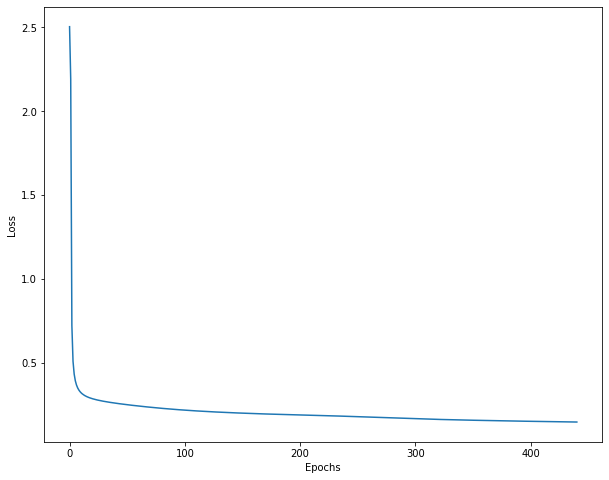

In [91]:
plt.figure(figsize=(10, 8))
plt.plot(errors, label='Loss on train DS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [92]:
print(test_loss)

0.18834417351795993


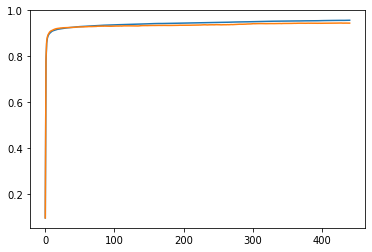

In [93]:
# acc_train, acc_test
plt.plot(acc_train, label='Acc train')
plt.plot(acc_test, label='Acc test')

# Test model

In [94]:
print(f'Accuracy on test set: {accuracy(X_test, y_test, W,b,f)}')

Accuracy on test set: 0.9446
